In [1]:
import os
import numpy as np
import pandas as pd
from Bio.PDB.MMCIF2Dict import MMCIF2Dict
import time
from itertools import cycle

from tqdm.notebook import tqdm
from importlib import reload
import pylab as plt
import seaborn as sns
from collections import Counter

from ipywidgets import widgets, Output, Tab
from IPython.display import display, clear_output


%matplotlib notebook
pd.options.display.max_rows = 200


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
from iraa_utils import writePDBSeleChains_v3 as pdbwriter
from iraa_utils import calcSASA_v3 as sasa
#from iraa_utils import file_selector as fs
from iraa_utils import IRAA_tools_v3 as iraa

In [3]:
%load_ext autoreload
%autoreload 2


# Jupyter Notebook GUI

* Run the cell below to generate the GUI
* Go through the GUI step-by-step

In [5]:
#Jupyter notebook GUI

layout = widgets.Layout(width='auto', height='40px') #set width and height
style = {'description_width': 'initial', 'button_color':'lightgreen', 'text_color':'blue'}

#========= Buttons =========================
#========= Buttons: Row-1 =========================
print("")
print("")
# print(" IRAA_iteract GUI ")
# print("")
# print("")
row1_text_filepath_A = widgets.Text(
    value=os.path.join(iraa.ov_dir, 'List_of_structures_A.txt'), #os.path.abspath('')
    placeholder='Path to txt file',
    description='Select file [A]:',
    layout=layout, style=style,
    disabled=False
)

row1_text_filepath_B = widgets.Text(
    value=os.path.join(iraa.ov_dir, 'List_of_structures_B.txt'), #os.path.abspath('')
    placeholder='Path to txt file',
    description='Select file [B]:',
    layout=layout, style=style,
    disabled=False
)

row1_text_filepath_AB = widgets.Text(
    value=os.path.join(iraa.ov_dir, 'List_of_structures_AB.txt'), #os.path.abspath('')
    placeholder='Path to txt file',
    description='Select file [AB]:',
    layout=layout, style=style,
    disabled=False
)

row1_text_filepath_drop_AB = widgets.Text(
    value=os.path.join(iraa.ov_dir, 'List_of_structures_AB_to_drop.txt'), #os.path.abspath('')
    placeholder='Path to txt file',
    description='Files [AB] to drop:',
    layout=layout, style=style,
    disabled=False
)

row1_button_readfiles = widgets.Button(description="Read files", layout={'width':"100%"})
#========= Buttons: Row-2 =========================

row2_button_create_pdbs = widgets.Button(description="Create PDB files per chain", \
                                         layout={'width':"100%"},\
                                          disabled=True)
row2_button_calc_sasa = widgets.Button(description="Calculate SASA", \
                                       layout={'width':"100%"},\
                                        disabled=True)
#========= Buttons: Row-3 =========================

row3_area_thr = widgets.BoundedFloatText(
    value=1.5,
    min=0.0,
    step=0.5,
    description='Area Thr. ($A^{2}$):',
    disabled=False,
    layout=widgets.Layout(flex='1 1 auto', width='auto'), #{'width':"stretch"}, 
    style=style
)

row3_count_thr = widgets.BoundedIntText(
    value=3,
    min=0,
    max=10,
    description='Count Thr.:',
    disabled=False,
    layout=widgets.Layout(flex='1 1 auto', width='auto'), #{'width':"stretch"}, 
    style=style
)

row3_button_ident_mpirs = widgets.Button(description="Identify most-probable interface residues", 
                                         layout=widgets.Layout(flex='5 1 auto', width='auto'), #{'width':"100%"},\
                                          disabled=True, button_style='success')

row4_dd_mpirs_list_A = widgets.SelectMultiple(options=['None'],description='Residues from A:',style=style, layout={'width':"stretch"})
row4_dd_mpirs_list_B = widgets.SelectMultiple(options=['None'],description='Residues from B:',style=style, layout={'width':"stretch"})
row4_MC_iterations = widgets.BoundedIntText(value=100,min=50,max=250,step=50,description='Monte Carlo iterations:',disabled=False,layout=widgets.Layout(flex='1 1 auto', width='auto'), #{'width':"stretch"}
                                            style=style)

row5_button_calc_bnd_bsa = widgets.Button(description="Calculate BSA from bound structures", \
                                         layout={'width':"100%"},\
                                          disabled=True)

row5_button_calc_MC_bsa = widgets.Button(description="Calculate BSA from MC method", \
                                       layout={'width':"100%"},\
                                        disabled=True, button_style='success')

#layout=Layout(flex='1 1 auto', width='auto'),


# row2_button_calc_sasa = widgets.Button(description="Calculate SASA", \
#                                        layout={'width':"100%"},\
#                                         disabled=True)



#========= Buttons box =========================

box_layout_flow_col = widgets.Layout(display='flex',
                flex_flow='column',
                align_items='stretch',
                width='100%',
                border='1px solid black')

box_layout_flow_row = widgets.Layout(display='flex',
                flex_flow='row',
                align_items='stretch',
                width='100%',
                border='1px solid black')


row_1 = widgets.HBox(children=[row1_text_filepath_A,row1_text_filepath_B,row1_text_filepath_AB,row1_text_filepath_drop_AB,row1_button_readfiles],layout=box_layout_flow_col)
row_2 = widgets.HBox(children=[row2_button_create_pdbs,row2_button_calc_sasa],layout=box_layout_flow_col)
row_3 = widgets.HBox(children=[row3_area_thr, row3_count_thr, row3_button_ident_mpirs],layout=box_layout_flow_row)
row_4 = widgets.HBox(children=[row4_dd_mpirs_list_A, row4_dd_mpirs_list_B, row4_MC_iterations],layout=box_layout_flow_row)
row_5 = widgets.HBox(children=[row5_button_calc_bnd_bsa, row5_button_calc_MC_bsa],layout=box_layout_flow_col)

buttons_ui = widgets.VBox([row_1, row_2, row_3, row_4, row_5], layout=box_layout_flow_col)
tab1 = Tab()
tab1.children = [buttons_ui]
tab1.set_title(0,["IRAA_interact GUI"])

#========= Buttons on-click =========================

# capture all print outputs into the list below
all_print_outputs = Output()

def row1_button_readfiles_on_click(b):
    global all_print_outputs, structures_of_A_fid_ch, structures_of_B_fid_ch, structures_of_AB_fid_ch, structures_of_AB_fid_ch_split
    try:
        structures_of_A_fid_ch, structures_of_B_fid_ch, structures_of_AB_fid_ch, structures_of_AB_fid_ch_split = \
                iraa.get_list_of_structures(row1_text_filepath_A.value, row1_text_filepath_B.value, \
                                            row1_text_filepath_AB.value, row1_text_filepath_drop_AB.value)
    except:
        print("Failed to read the txt files. Check the format of the files.")
    a = [structures_of_A_fid_ch, structures_of_B_fid_ch, structures_of_AB_fid_ch, structures_of_AB_fid_ch_split]
    with all_print_outputs:
        print("Structures of [A]: ", len(a[0]), " | Structures of [B]", len(a[1]), " | Structures of [AB]", len(a[2])) 
    a = [len(v)>1 for v in a]
    if np.product(np.array(a)) >= 1:
        row2_button_create_pdbs.disabled = False
    
def row2_button_create_pdbs_on_click(b):
    all_print_outputs.clear_output()
    try:
        with all_print_outputs:
            print("Creating (if) missing PDB files per chain.")
            structures_of_A_fid_ch, structures_of_B_fid_ch, structures_of_AB_fid_ch, structures_of_AB_fid_ch_split = \
                iraa.get_list_of_structures(row1_text_filepath_A.value, row1_text_filepath_B.value, \
                                            row1_text_filepath_AB.value, row1_text_filepath_drop_AB.value)
            for p_list in [structures_of_A_fid_ch, structures_of_B_fid_ch, structures_of_AB_fid_ch, structures_of_AB_fid_ch_split]:
                iraa.gen_pbd_files_per_chain(p_list)
        row2_button_calc_sasa.disabled = False
    except:
        print("Problem creating PDB files per chain.")
    pass
 
def row2_button_calc_sasa_on_click(b):
    global all_print_outputs, df_sasa_all, df_seq_all
    all_print_outputs.clear_output(wait=True)
    try:
        with all_print_outputs:
            iraa.gen_sasa_files()
    except:
        print("Problem creating SASA calculations.")
    #==========
    try:
        with all_print_outputs:
            print("Reading all SASA.")
            df_sasa_all = iraa.get_sasa_df_all()
        time.sleep(1)
        all_print_outputs.clear_output(wait=True)
        with all_print_outputs:
            print("Reading all sequences.")
            df_seq_all = iraa.get_seq_df_all()
        row3_button_ident_mpirs.disabled = False
    except:
        print("Problem reading SASA files.")
    pass

def row3_button_ident_mpirs_on_click(b):
    global all_print_outputs, df_bsa_A, df_bsa_B, df_bsa, df_intf_resi_A_and_B, df_sasa_all, df_seq_all, idxs_A, idxs_B, idxs_A_res_with_id, idxs_B_res_with_id
    all_print_outputs.clear_output()
    try:
        df_bsa_A, df_bsa_B = iraa.get_bsa_bound_all_residues(df_sasa_all)
        df_bsa = pd.concat([df_bsa_A, df_bsa_B], axis=1)
        #===========
        df_intf_resi_A_and_B = iraa.get_df_most_prob_intf_resi(df_seq_all, df_bsa_A, df_bsa_B, area_thr = row3_area_thr.value, count_thr = row3_count_thr.value)
        #===========
        idxs_A, idxs_B, idxs_A_res_with_id, idxs_B_res_with_id = iraa.get_list_of_most_prob_intf_resi(df_intf_resi_A_and_B)
        row4_dd_mpirs_list_A.options = list(zip(idxs_A_res_with_id, idxs_A))
        row4_dd_mpirs_list_B.options = list(zip(idxs_B_res_with_id, idxs_B))
        row5_button_calc_bnd_bsa.disabled = False
        print( "No. of most-probable IRs of A: ", len(idxs_A), " | No. of most-probable IRs of B: ", len(idxs_B))
    except:
        print("Problem identifying mpirs.")
    pass

def row5_button_calc_bnd_bsa_on_click(b):
    global bnd_bsa_A, bnd_bsa_B, bound_BSAs, structures_of_B_fid_ch, df_asa_unbd_A, df_asa_unbd_B, updated_list_to_drop, \
            of_A_fid_ch, structures_of_B_fid_ch, structures_of_AB_fid_ch, structures_of_AB_fid_ch_split
    try:
        bnd_bsa_A, bnd_bsa_B, bound_BSAs = iraa.get_BSA_from_bound_intf_residues(df_sasa_all, idxs_A, idxs_B)
        row5_button_calc_MC_bsa.disabled = False
        print("Avg. BSA from bound structures: ", np.round(np.mean(bound_BSAs),1))
        #=== Remove unbound structrues of B with missing values for interface residues.
        df_asa_unbd_A, df_asa_unbd_B = iraa.get_asa_unbound(df_sasa_all)
        mask = (df_asa_unbd_B.loc[idxs_B].isna().sum(0) == 0).values
        n_B_bnd_old = len(structures_of_B_fid_ch)
        updated_list_to_drop = list(set(structures_of_B_fid_ch) - set([v for v in structures_of_B_fid_ch if v in df_asa_unbd_B.columns[mask]]))
        structures_of_B_fid_ch = [v for v in structures_of_B_fid_ch if v in df_asa_unbd_B.columns[mask]]
        df_asa_unbd_B = df_asa_unbd_B[df_asa_unbd_B.columns[mask]]
        n_B_bnd_new = len(structures_of_B_fid_ch)
        print("Check unbound structures with missing values in interface residues:")
        print(np.round(n_B_bnd_old-n_B_bnd_new,0), " unbound structures of B dropped.")
        iraa.updated_list_to_drop = updated_list_to_drop
        structures_of_A_fid_ch, structures_of_B_fid_ch, structures_of_AB_fid_ch, structures_of_AB_fid_ch_split = \
                iraa.get_list_of_structures(row1_text_filepath_A.value, row1_text_filepath_B.value, \
                                            row1_text_filepath_AB.value, row1_text_filepath_drop_AB.value)
        print("Structures:")
        print("Total files/chains per file of A: ", len(set([v[:4] for v in structures_of_A_fid_ch])), "/", len(structures_of_A_fid_ch))
        print("Total files/chains per file of B: ", len(set([v[:4] for v in structures_of_B_fid_ch])), "/", len(structures_of_B_fid_ch))
        print("Total files/chains per file of AB complexed: ", len(set([v[:4] for v in structures_of_AB_fid_ch])), "/", len(structures_of_AB_fid_ch))
    except:
        print("Problem in calculating BSA from bound structures.")
    
def row5_button_calc_MC_bsa_on_click(b):
    global df_MC_BSA_A, df_MC_BSA_B, MC_BSAs
    try:
        print("Calculate MC BSA over ", row4_MC_iterations.value, " iterations:")
        df_MC_BSA_A, df_MC_BSA_B, MC_BSAs = iraa.get_Monte_Carlo_BSAs(df_sasa_all, idxs_A, idxs_B, iterations=row4_MC_iterations.value)
        print("Avg. BSA from MC method (combined un/bound): ", np.round(np.mean(MC_BSAs),1))
    except:
        print("Problem in calculating BSA from Monte Carlo Method.")
    
row1_button_readfiles.on_click(row1_button_readfiles_on_click)
row2_button_create_pdbs.on_click(row2_button_create_pdbs_on_click)
row2_button_calc_sasa.on_click(row2_button_calc_sasa_on_click)
row3_button_ident_mpirs.on_click(row3_button_ident_mpirs_on_click)
row5_button_calc_bnd_bsa.on_click(row5_button_calc_bnd_bsa_on_click)
row5_button_calc_MC_bsa.on_click(row5_button_calc_MC_bsa_on_click)

#========= Buttons display =========================
display(tab1) #buttons_ui
display(all_print_outputs)

Output()

No. of most-probable IRs of A:  32  | No. of most-probable IRs of B:  38
No. of most-probable IRs of A:  32  | No. of most-probable IRs of B:  36
No. of most-probable IRs of A:  32  | No. of most-probable IRs of B:  38
Avg. BSA from bound structures:  1808.4
Check unbound structures with missing values in interface residues:
166  unbound structures of B dropped.
Structures:
Total files/chains per file of A:  4 / 6
Total files/chains per file of B:  121 / 340
Total files/chains per file of AB complexed:  76 / 98


# Visualizations

## Heatmap of BSAs

<IPython.core.display.Javascript object>


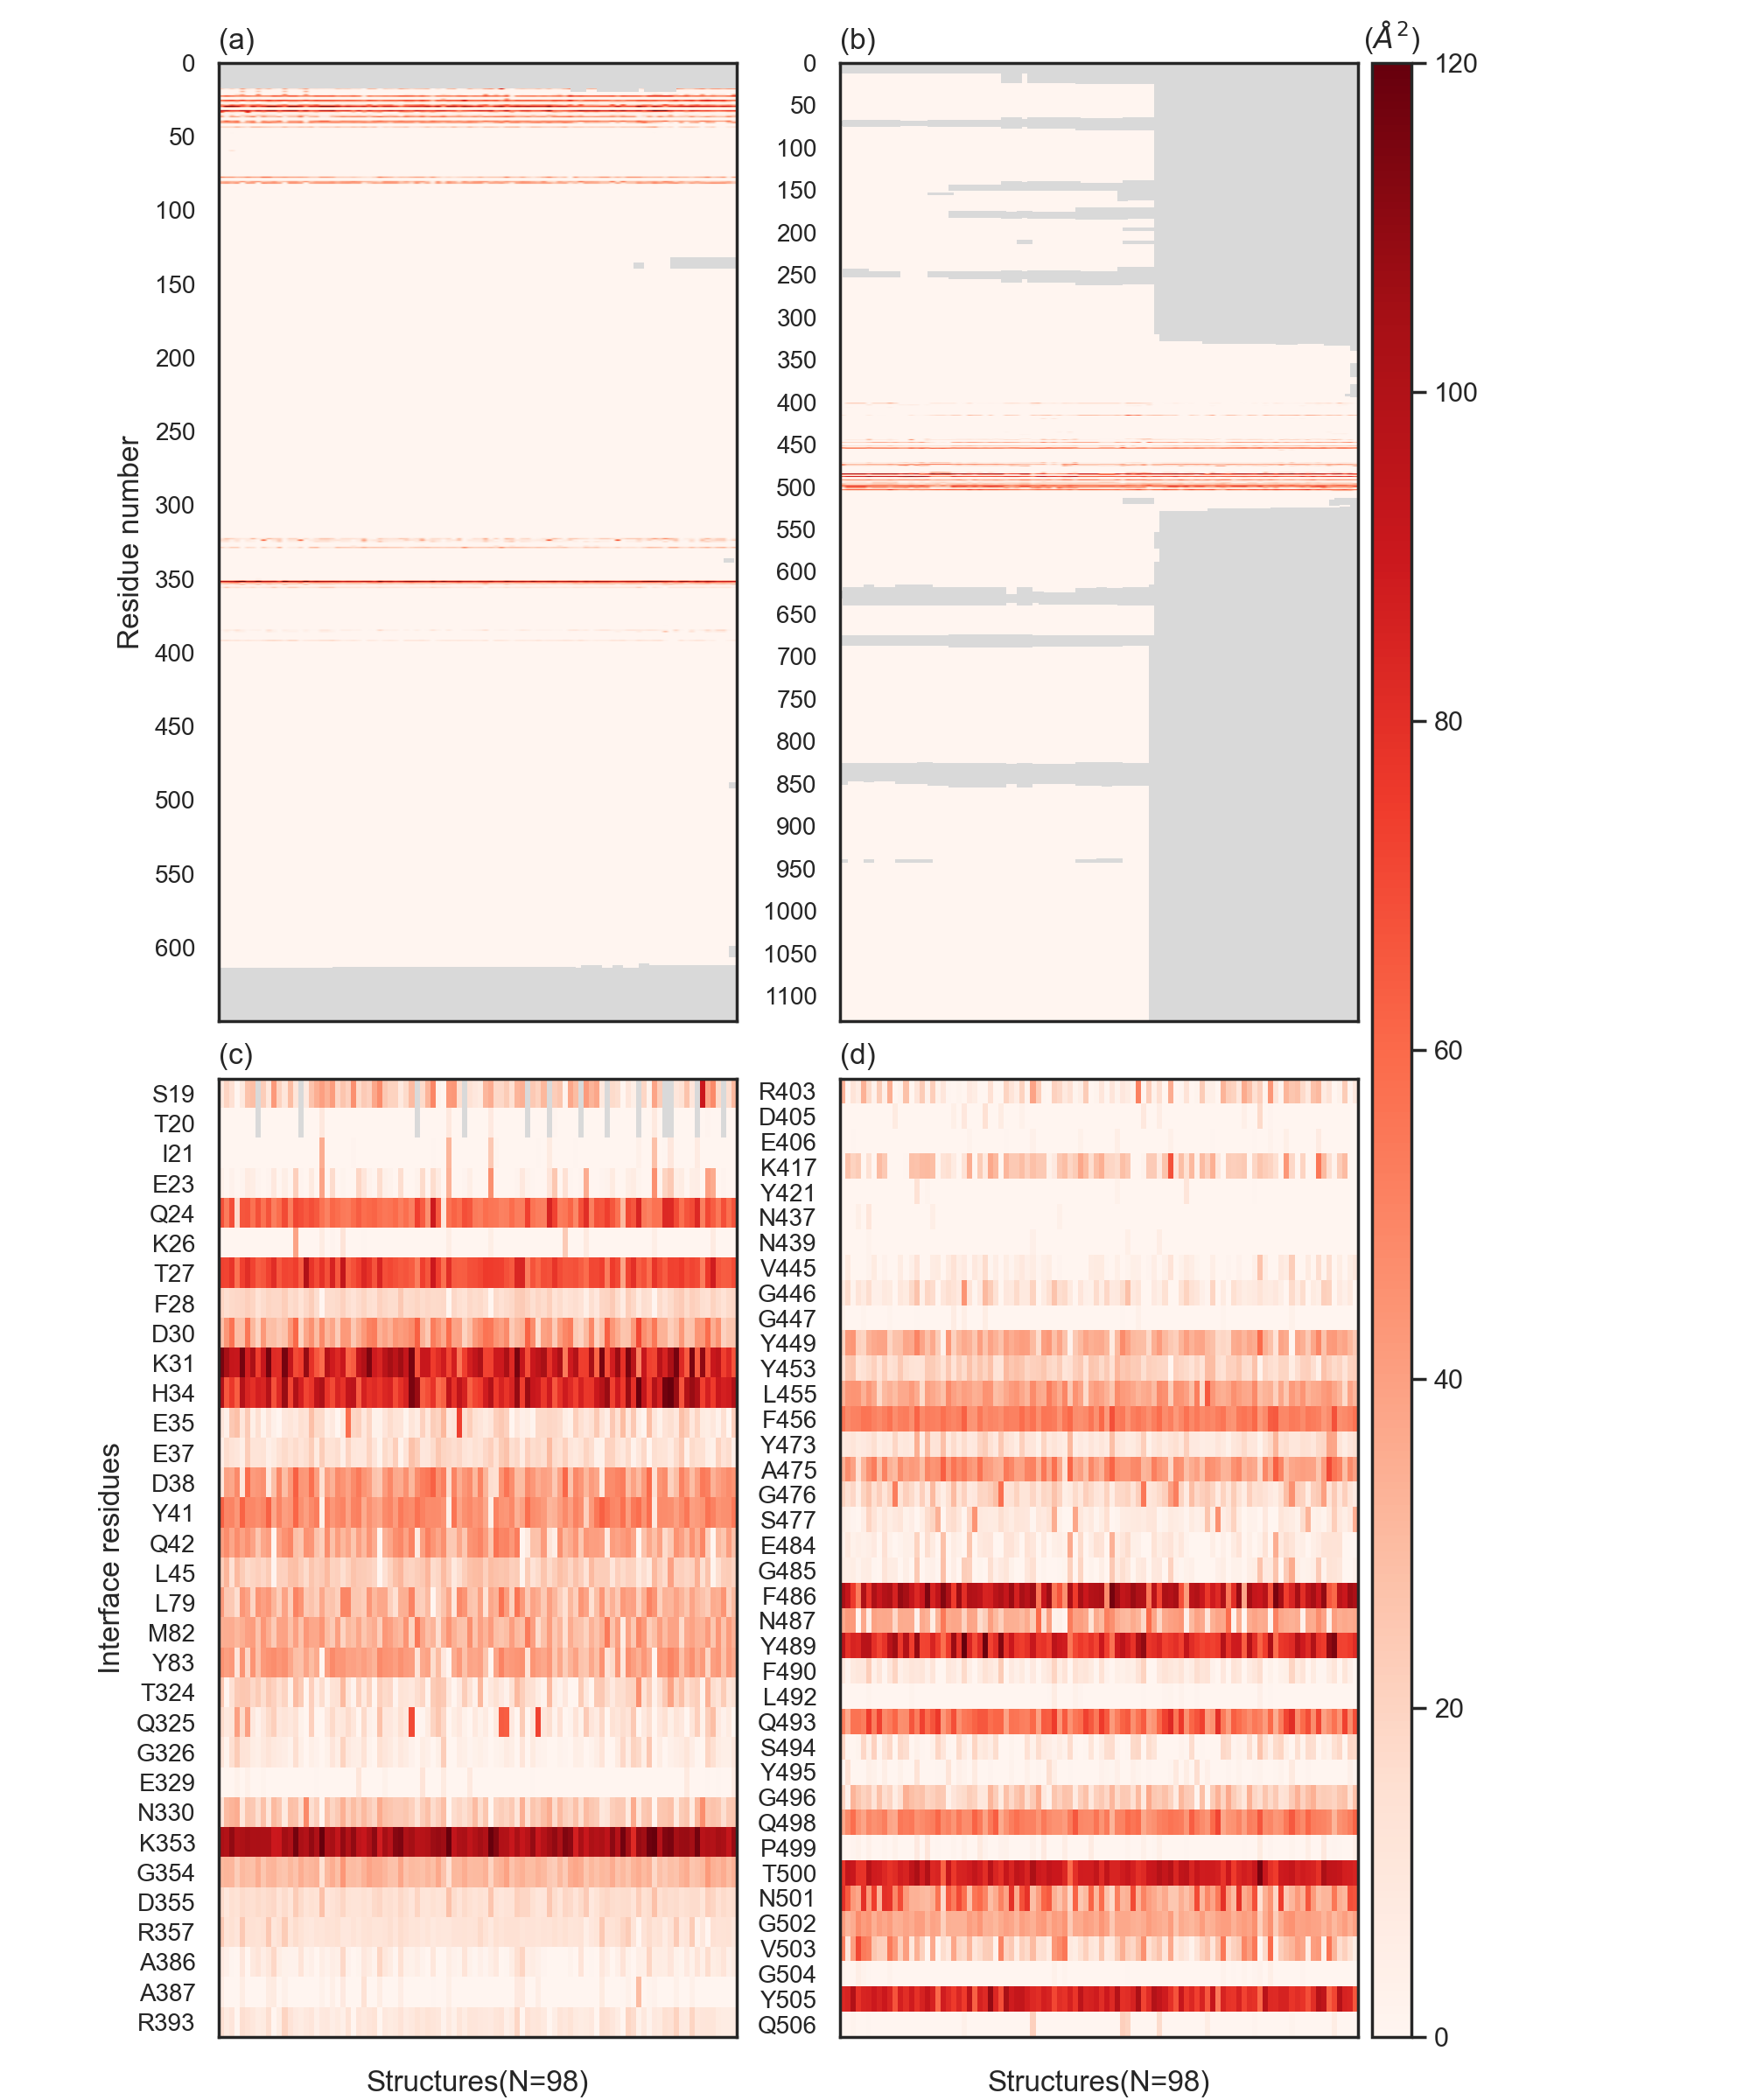

/var/folders/ct/_1swjkjj5k99zkbfxbxmz7mm0000gn/T/ipykernel_85875/1541576145.py:14: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(left=None, right=None, top=0.97, bottom=0.03, wspace=0.2, hspace=0.06)


Text(0, 0.5, 'Interface residues')

In [79]:
# Edit below block according to your data. 
#plt.figure()
N=len(structures_of_AB_fid_ch)
cmap_style = plt.cm.Reds.copy()
cmap_style.set_bad('gray',0.3)
fig, axs = plt.subplots(2,2,figsize=(10,12), edgecolor='k')
axs=axs.flatten()
axs[0].imshow(df_bsa_A[df_bsa_A.isna().sum().sort_values().keys()], aspect='auto', vmax=120, vmin=0, cmap=cmap_style)
axs[2].imshow(df_bsa_A.loc[idxs_A],aspect='auto',vmax=120, vmin=0, cmap=cmap_style)
axs[1].imshow(df_bsa_B[df_bsa_B.isna().sum().sort_values().keys()],aspect='auto',vmax=120, vmin=0, cmap=cmap_style)
im = axs[3].imshow(df_bsa_B.loc[idxs_B],aspect='auto',vmax=120, vmin=0, cmap=cmap_style)

#plt.tight_layout()
plt.subplots_adjust(left=None, right=None, top=0.97, bottom=0.03, wspace=0.2, hspace=0.06)
cbar = fig.colorbar(im, ax=axs.ravel().tolist(), pad=0.01, aspect=50)
cbar.ax.set_title("($\AA^{2}$)", fontsize=12)

subplot_labels = ["(a)", "(b)", "(c)", "(d)"]
for i in [0,1,2,3]:
    axs[i].grid(False)
    axs[i].set_xticks([])
    axs[i].text(0.0, 1.015, subplot_labels[i], transform=axs[i].transAxes, size=12)
    
#A:top-left
axs[0].set_yticks(np.arange(0,650,50))
axs[0].set_yticklabels(np.arange(0,650,50), fontsize=10)
axs[0].set_ylim(650,0)

#B:top-right
axs[1].set_yticks(np.arange(0,1150,50))
axs[1].set_yticklabels(np.arange(0,1150,50), fontsize=10)
axs[1].set_ylim(1130,0)

#A:bottom-left
axs[2].set_yticks(np.arange(0,len(idxs_A)))
axs[2].set_yticklabels(idxs_A_res_with_id, fontsize=10)

#B:bottom-right
axs[3].set_yticks(np.arange(0,len(idxs_B)))
axs[3].set_yticklabels(idxs_B_res_with_id, fontsize=10)

#
axs[2].set_xticks(np.arange(0,100,10))
axs[2].set_xticklabels([])
axs[2].set_xlabel("Structures(N=%i)"%N, fontsize=12)

#
axs[3].set_xticks(np.arange(0,100,10))
axs[3].set_xticklabels([])
axs[3].set_xlabel("Structures(N=%i)"%N, fontsize=12)

#
axs[0].set_ylabel("Residue number", fontsize=12)
axs[2].set_ylabel("Interface residues", fontsize=12)

# fname = "heatmaps_bsa_AB.eps"
# fname = os.path.join(iraa.fig_dir,fname)
# plt.savefig(fname, dpi=1200, transparent=True)

In [80]:
df_asa_unbd_A, df_asa_unbd_B = iraa.get_asa_unbound(df_sasa_all)
df_asa_bound_A_iso, df_asa_bound_A_compx, df_asa_bound_B_iso, df_asa_bound_B_compx = iraa.get_asa_bound(df_sasa_all)
df_asa_unbd_B.shape

(1226, 340)

<IPython.core.display.Javascript object>


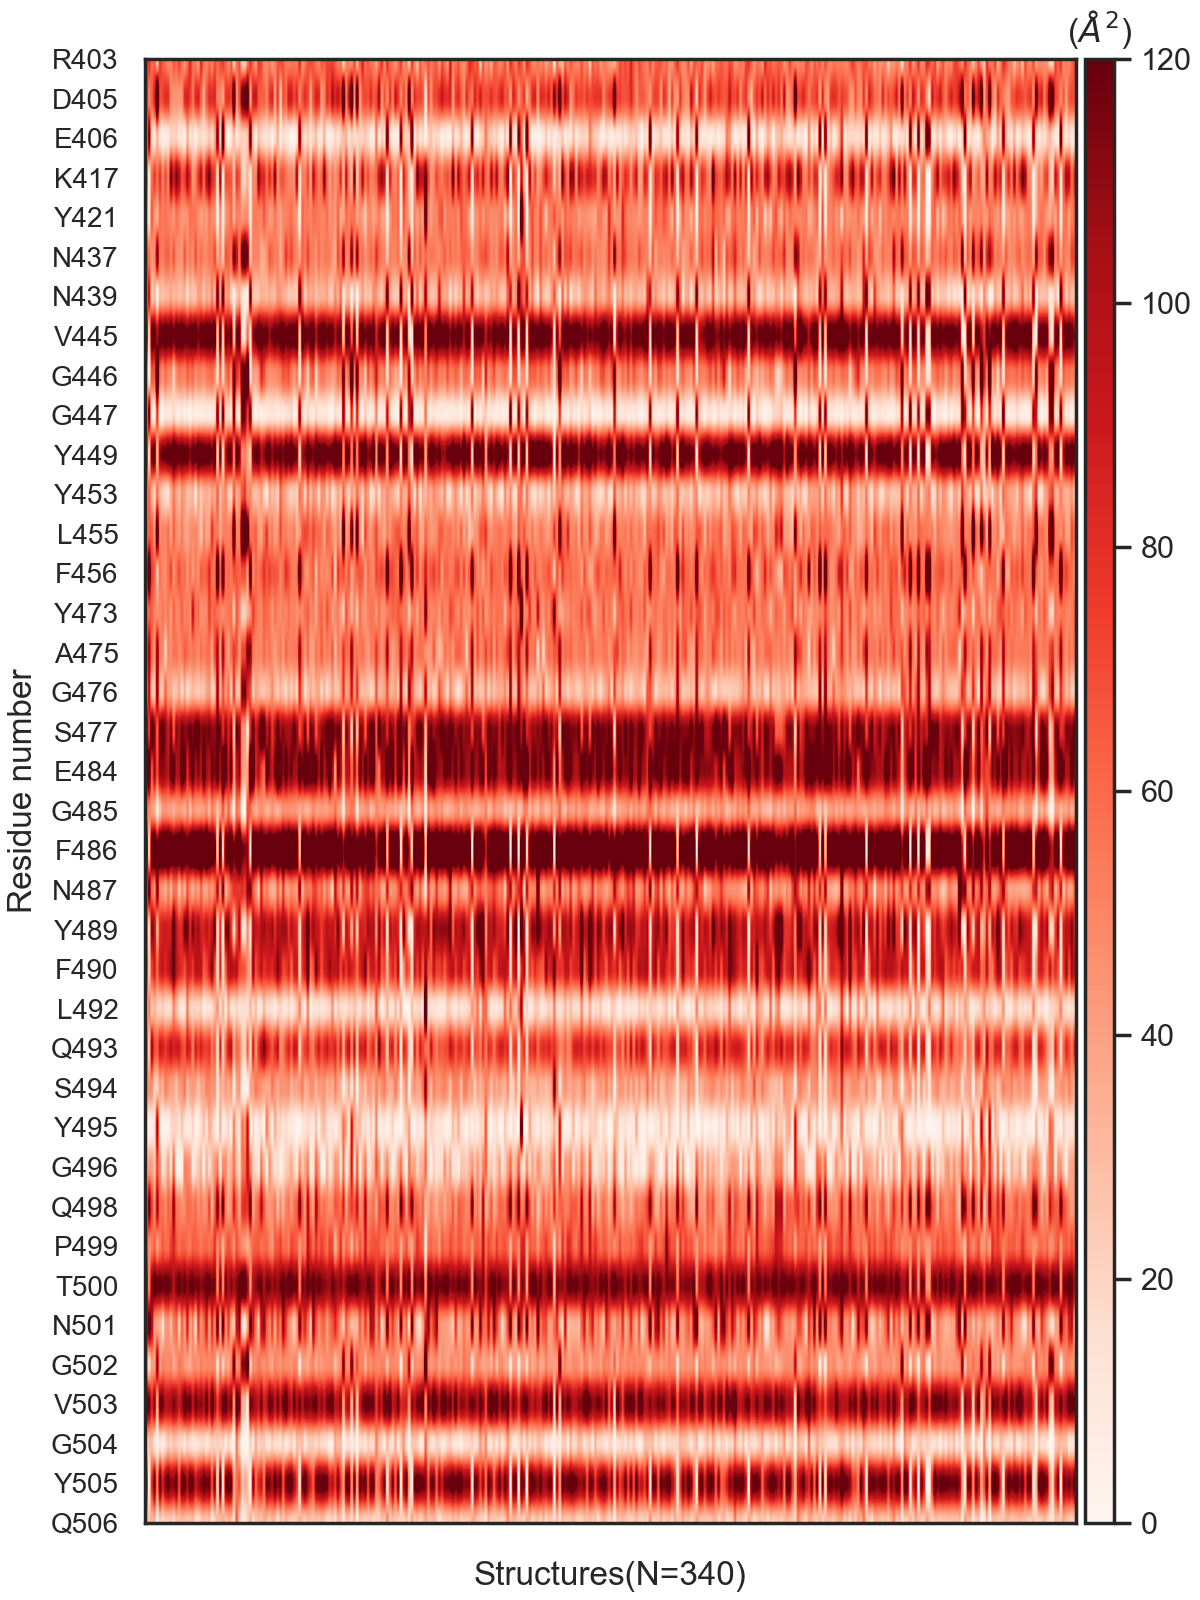

Text(0, 0.5, 'Residue number')

In [81]:
# ASA values of unbound B

N=df_asa_unbd_B.loc[idxs_B].shape[1]
cmap_style = plt.cm.Reds.copy()
cmap_style.set_bad('gray',0.3)
fig, ax = plt.subplots(1,1,figsize=(6,8), edgecolor='k')
#B:top-right
ax.set_yticks(np.arange(0,1150,50))
ax.set_yticklabels(np.arange(0,1150,50), fontsize=10)
ax.set_ylim(len(idxs_B)-1,0)
im = ax.imshow(df_asa_unbd_B.loc[idxs_B],aspect='auto',vmax=120, vmin=0, cmap=cmap_style)
cbar = fig.colorbar(im, pad=0.01, aspect=50)
cbar.ax.set_title("($\AA^{2}$)", fontsize=12)
#ax.set_xticks([])

ax.set_xticklabels([])
ax.set_xlabel("Structures(N=%i)"%N, fontsize=12)
ax.set_yticks(np.arange(0,len(idxs_B)))
ax.set_yticklabels(idxs_B_res_with_id, fontsize=10)

#
ax.set_ylabel("Residue number", fontsize=12)
#ax.set_ylabel("Interface residues", fontsize=12)

# fname = "heatmaps_asa_unbnd_B_intf.eps"
# fname = os.path.join(iraa.fig_dir,fname)
# plt.savefig(fname, dpi=1200, transparent=True)

## Compare BSA per residue 'from Bound structures' vs 'MC method combining Unbound-Bound structures'

In [82]:
df_MC_vs_bnd_bsa_A, df_MC_vs_bnd_bsa_expd_A = iraa.get_df_sidebyside_MC_Bnd(df_MC_BSA_A, bnd_bsa_A, idxs_A, idxs_A_res_with_id)
df_MC_vs_bnd_bsa_B, df_MC_vs_bnd_bsa_expd_B = iraa.get_df_sidebyside_MC_Bnd(df_MC_BSA_B, bnd_bsa_B, idxs_B, idxs_B_res_with_id)

<IPython.core.display.Javascript object>


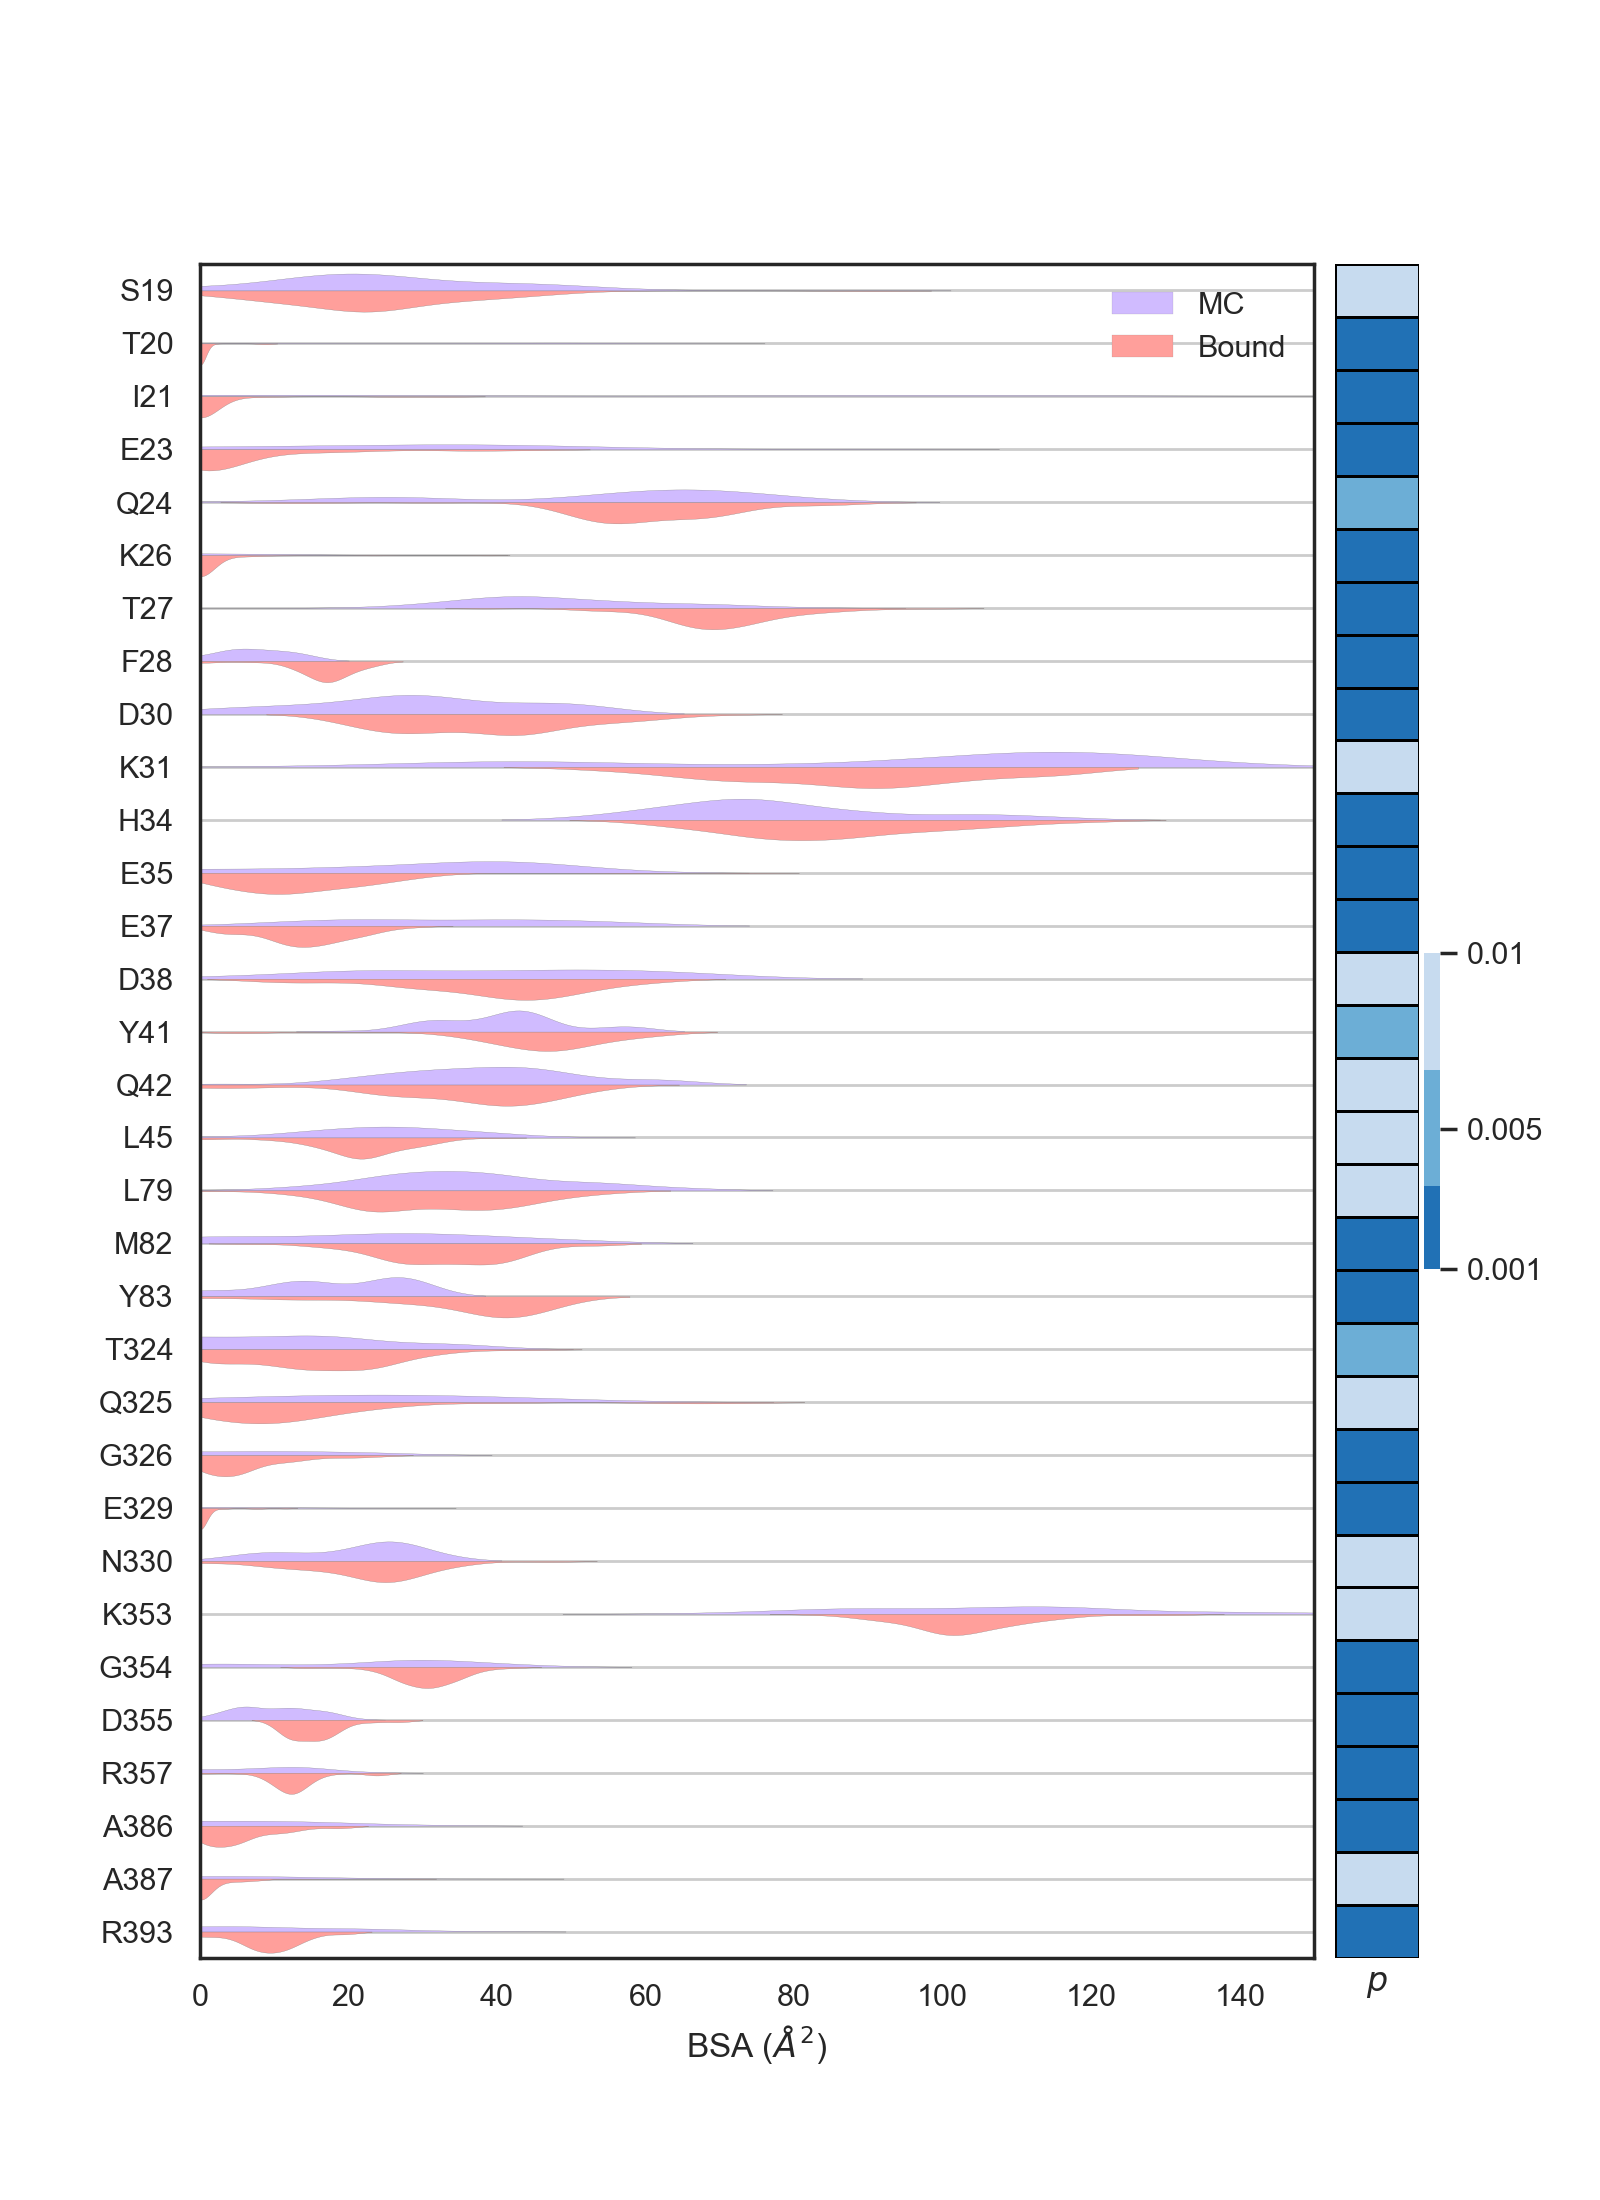

/Users/jaydeep/WorkDir/anaconda3/anaconda3/lib/python3.8/site-packages/seaborn/utils.py:95: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.draw()
/Users/jaydeep/WorkDir/MyPythonScripts/iraa_utils/IRAA_tools_v3.py:720: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  #[ sns.color_palette("pastel")[-1], sns.color_palette("pastel")[-2]]


<IPython.core.display.Javascript object>


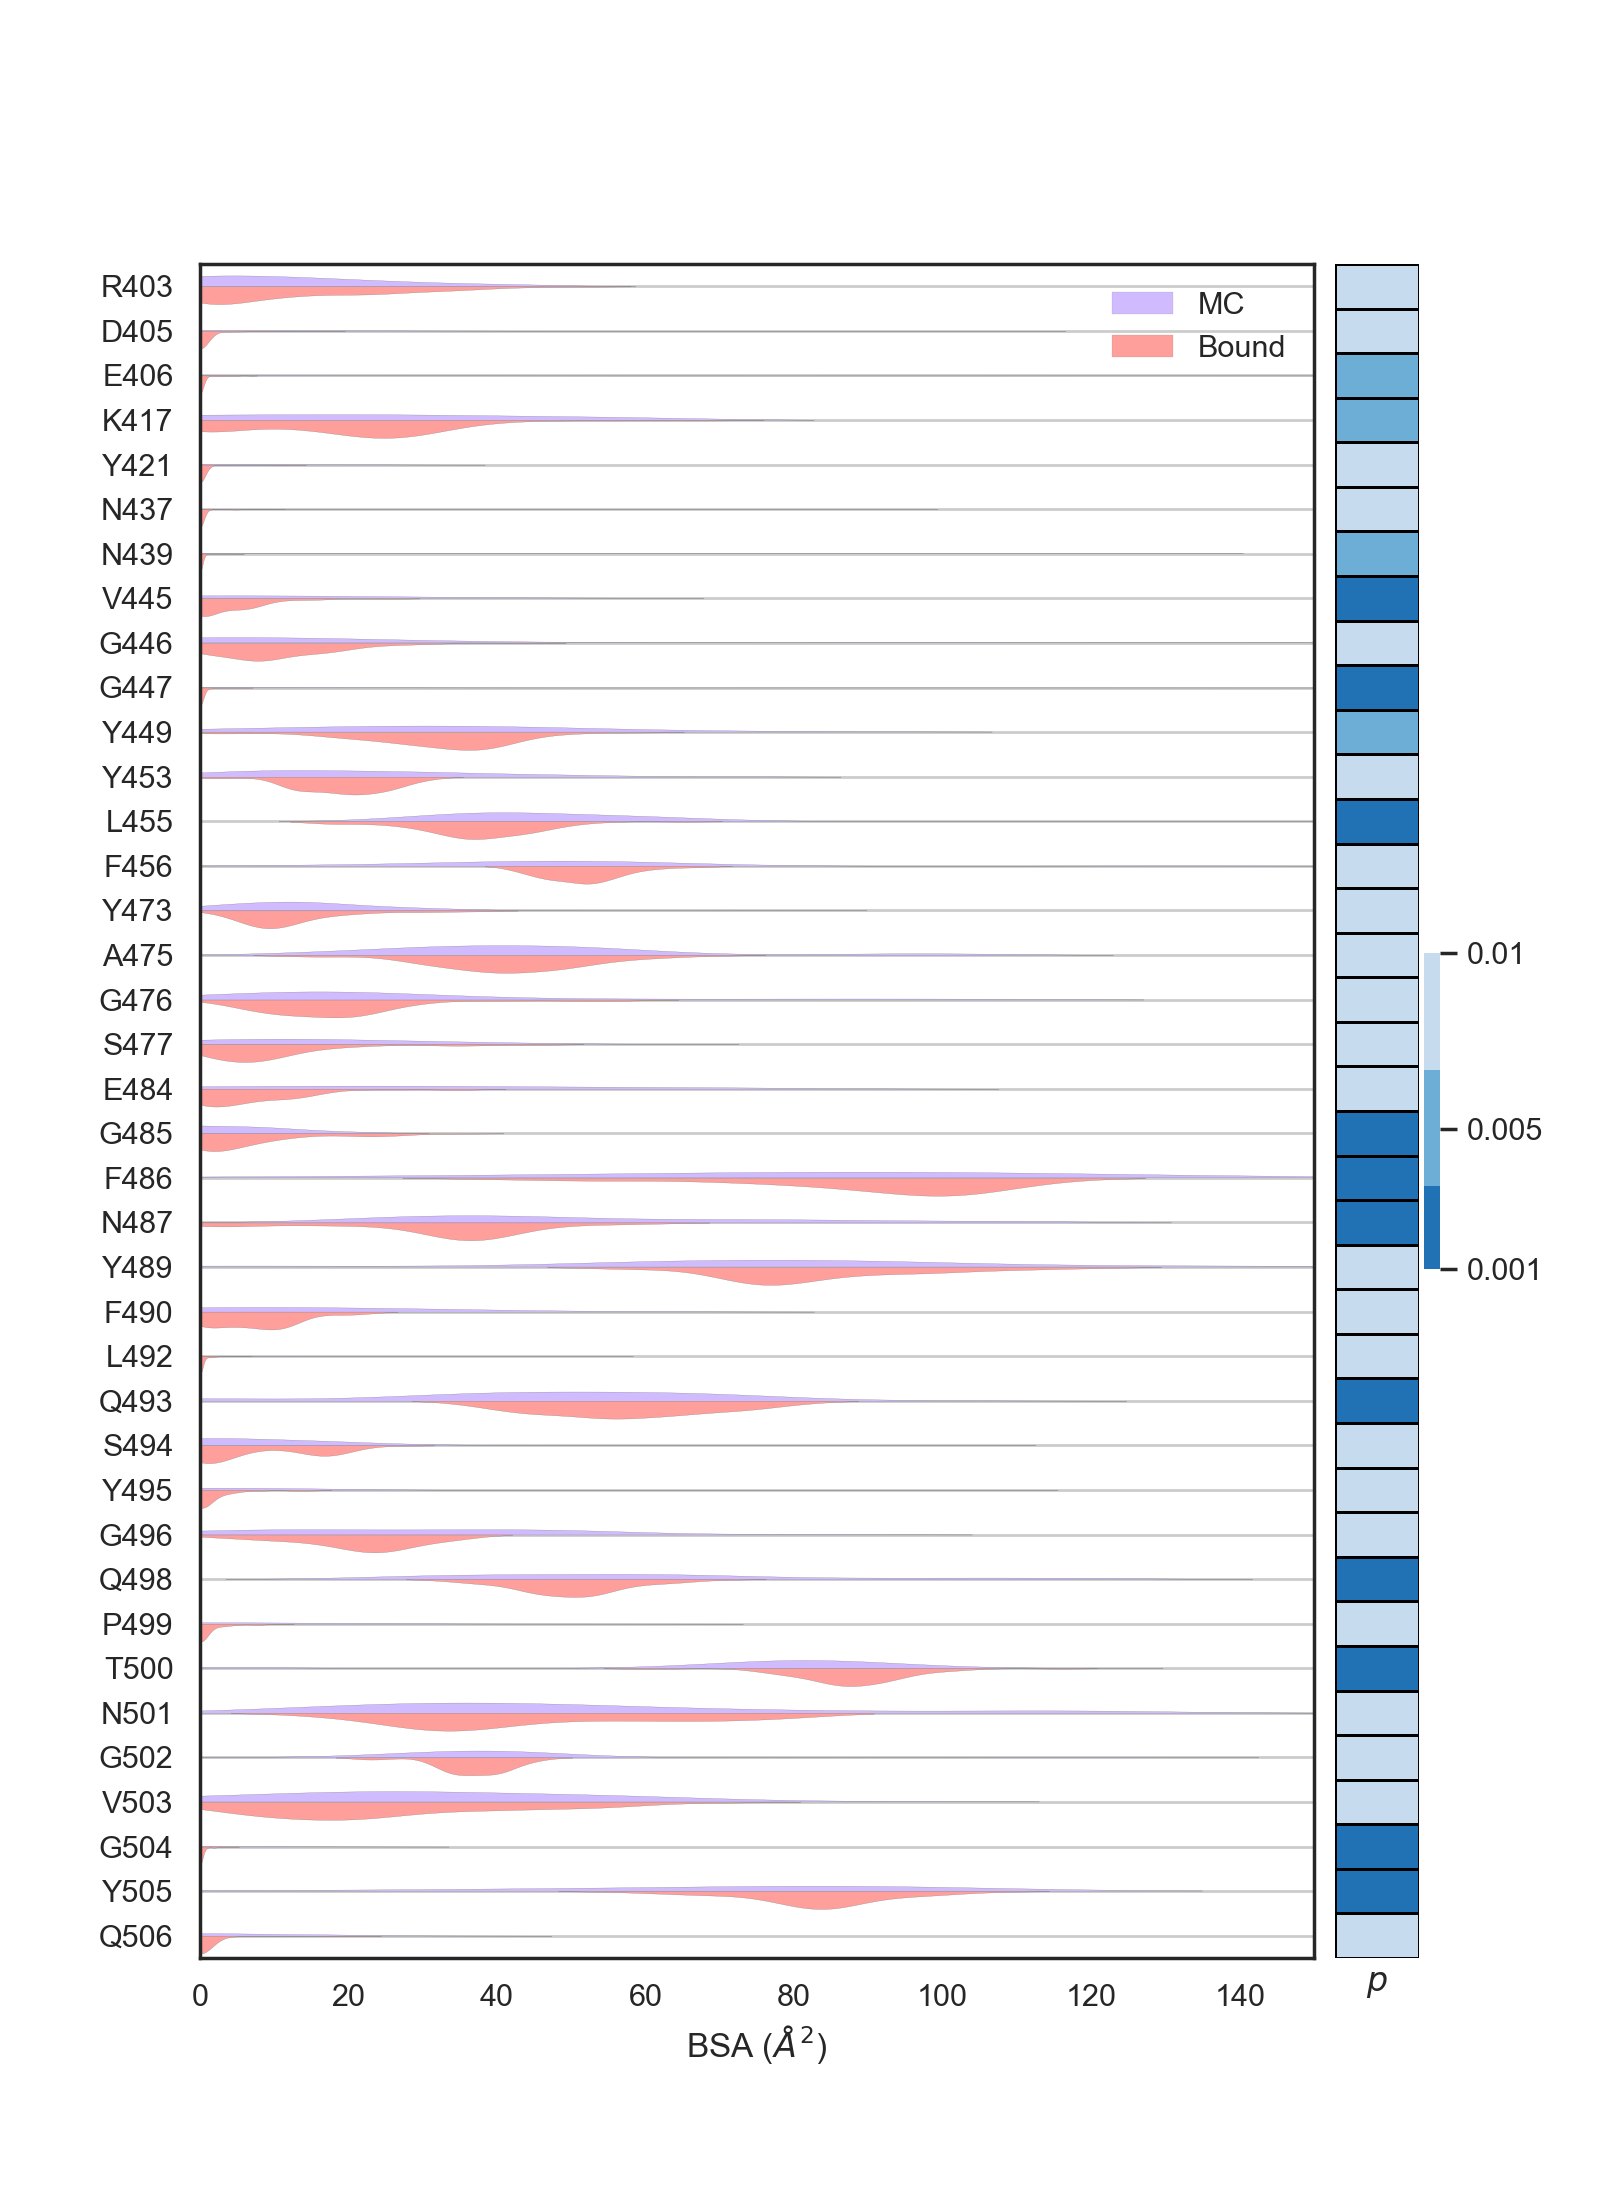

/Users/jaydeep/WorkDir/anaconda3/anaconda3/lib/python3.8/site-packages/seaborn/utils.py:95: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.draw()
/Users/jaydeep/WorkDir/MyPythonScripts/iraa_utils/IRAA_tools_v3.py:720: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  #[ sns.color_palette("pastel")[-1], sns.color_palette("pastel")[-2]]


In [84]:
iraa.plot_compare_MC_vs_Bnd_bsa_per_resi(df_MC_vs_bnd_bsa_A, df_MC_vs_bnd_bsa_expd_A, savefig=False, filename="bsa_A_intf_Bnd_vs_MC.eps", fig_dir=iraa.fig_dir)
iraa.plot_compare_MC_vs_Bnd_bsa_per_resi(df_MC_vs_bnd_bsa_B, df_MC_vs_bnd_bsa_expd_B, savefig=False, filename="bsa_B_intf_Bnd_vs_MC.eps", fig_dir=iraa.fig_dir)


## Compare total BSA 'from Bound structures' vs 'MC method combining Unbound-Bound structures'

In [86]:
df_comp_bsa_A, df_comp_bsa_B, df_comp_bsa_total_Aplus_B = iraa.get_df_total_bsa_MC_vs_Bnd(bnd_bsa_A, bnd_bsa_B, bound_BSAs, df_MC_BSA_A, df_MC_BSA_B, MC_BSAs)


<IPython.core.display.Javascript object>


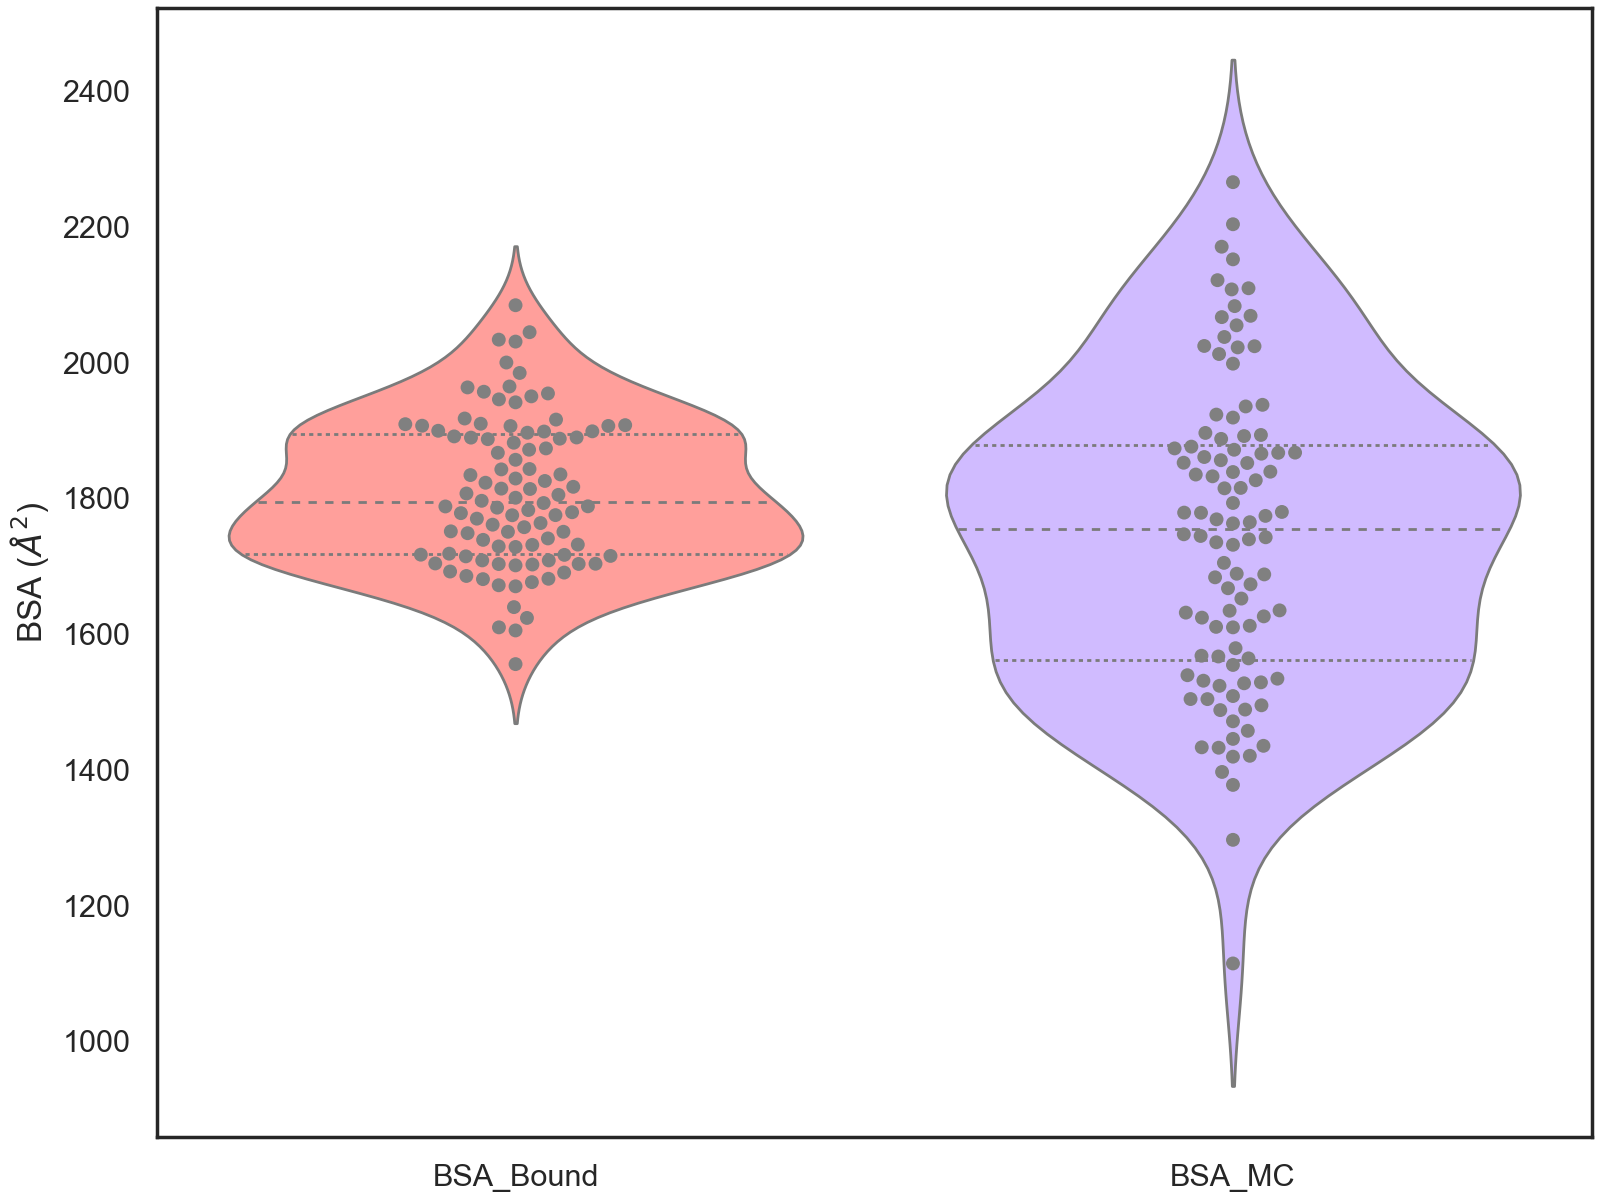

In [88]:
iraa.plot_compare_MC_vs_Bnd_bsa_total_over_intf_resi(df_comp_bsa_total_Aplus_B, savefig=False, filename="total_bsa_intf_Bnd_vs_MC_v2.eps", fig_dir=iraa.fig_dir)
